<a href="https://colab.research.google.com/github/gremoni/PCS5787_Grupo_5/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt 
import seaborn as sn

In [2]:
df = pd.read_csv('https://zenodo.org/record/5774093/files/Agragado.csv?download=1')

In [3]:
#exclusão das colunas que apresentam apenas dados do hardware da estação (tensão da bateria e temperatura do CPU) e da coluna de Pressão Atmosférica Reduzida ao Nível do Mar, por apresentar uma grande quantidade de observações ausentes
df = df.drop(['PRESSAOATMOSFERICAREDUZIDANIVELDOMAR', 'TENSAODABATERIADAESTACAO', 'TEMPERATURADACPUDAESTACAO'], 1)

In [4]:
#exclusão das linhas que possuem dados faltantes
df = df.dropna()

In [5]:
# cria uma nova coluna contendo o dado binário de ocorrência (1) ou não (0) de focos de incêndio
def label_focos (row):
   if row['Focos'] == 0 :
      return 0
   return 1

df['Focos_bin'] = df.apply(lambda row: label_focos(row), axis=1)

In [6]:
#cria o dataframe "sim" apenas com as observações binárias de foco iguais a 1
sim = df[df['Focos_bin'] == 1]

#cria o dataframe "não" apenas com as observações binárias de foco iguais a 0
nao = df[df['Focos_bin'] == 0]

In [7]:
#cria o dataframe "nao_bal", selecionando do dataframe "nao" de maneira aleatória a mesma quantidade de linhas existentes no dataframe "sim" 
nao_bal = nao.sample(n = len(sim), random_state=0)

In [8]:
#cria o dataframe balanceado "df_bal", com a mesma quantidade de observações cujo atributo binário é 1 e 0 
df_bal = pd.concat([sim, nao_bal])

In [9]:
# cria o dataframe pronto para a modelegam envolvendo algoritmos de classificação binária, removendo as colunas de data e número de focos 
dff = df_bal.drop(['Data', 'Focos'], 1)

In [10]:
# separa o dataframe dff em dois dataframes: o X contendo os atributos para treinamento dos modelos e o y com a variável target ("Focos_bin")
X = dff.loc[:, dff.columns != 'Focos_bin']
y = dff.loc[:, dff.columns == 'Focos_bin']

In [11]:
# normaliza as variáveis de treinamento
X_norm = preprocessing.normalize(X, axis=0)

#reescreve os nomes das colunas para melhor visualização
names = X.columns
X_norm_df = pd.DataFrame(X_norm, columns=names)

In [12]:
# define as amostras de treino (88%) e de teste (12%)
X_train, X_test, y_train, y_test = train_test_split(
X_norm_df, y, train_size=0.88)

In [13]:
# cria o modelo Random Forest com os parâmetros 
rf = RandomForestClassifier(n_estimators=145,
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             bootstrap=True, 
                             oob_score=False, 
                             n_jobs=-1, 
                             random_state=1, 
                             verbose=1, 
                             warm_start=False, 
                             class_weight=None, 
                             ccp_alpha=0.0, 
                             max_samples=None)

In [14]:
# realiza o treinamento do modelo classificador Random Forest por meio da amostra de treinamento
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    1.2s finished


RandomForestClassifier(min_samples_split=10, n_estimators=145, n_jobs=-1,
                       random_state=1, verbose=1)

In [15]:
# faz a classificação da amostra de teste com o modelo treinado
classificacao = rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.1s finished


In [16]:
print("Acurácia (treino): {0:.5f}".format(rf.score(X_train, y_train)))

print('Acurácia (teste): {:.5f}'.format(accuracy_score(y_test, classificacao)))
print('Precisão (teste): {:.5f}'.format(precision_score(y_test, classificacao)))
print('Revocação (teste): {:.5f}'.format(recall_score(y_test, classificacao)))
print('F1: {:.5f}'.format(f1_score(y_test, classificacao)))

print("Classification Report")
print(classification_report(y_test, classificacao))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.1s finished


Acurácia (treino): 0.95485
Acurácia (teste): 0.81406
Precisão (teste): 0.79379
Revocação (teste): 0.83881
F1: 0.81567
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       348
           1       0.79      0.84      0.82       335

    accuracy                           0.81       683
   macro avg       0.81      0.81      0.81       683
weighted avg       0.82      0.81      0.81       683



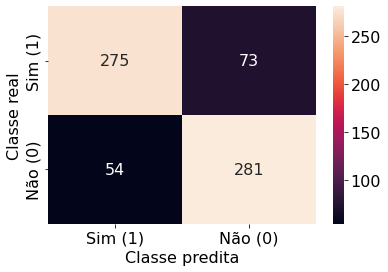

In [23]:
# Plota matriz de confusão
matriz = confusion_matrix(y_test, classificacao)
ax= plt.subplot()
sn.heatmap(matriz, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Classe predita');ax.set_ylabel('Classe real'); 
#ax.set_title('Matriz de confusão para ocorrência de incêndio'); 
ax.xaxis.set_ticklabels(['Sim (1)', 'Não (0)']); ax.yaxis.set_ticklabels(['Sim (1)', 'Não (0)']);

In [18]:
# previsão probabilísica do atributo binário 1 (incêndio) para elaboração da curva ROC
train_probs = rf.predict_proba(X_train)[:,1]
probs = rf.predict_proba(X_test)[:, 1]
train_predictions = rf.predict(X_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.1s finished


ROC AUC Score (Treino): 0.9940181692062422
ROC AUC Score (Teste): 0.8873434551381028


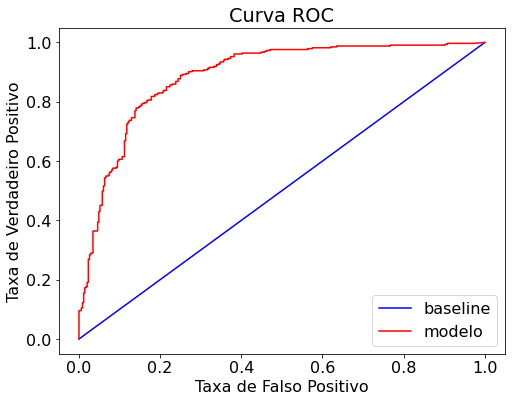

In [24]:
def evaluate_model(classificacao, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, classificacao)
    results['precision'] = precision_score(y_test, classificacao)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)

    print(f'ROC AUC Score (Treino): {roc_auc_score(y_train, train_probs)}')
    print(f'ROC AUC Score (Teste): {roc_auc_score(y_test, probs)}')


    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'modelo')
    plt.legend();
    plt.xlabel('Taxa de Falso Positivo');
    plt.ylabel('Taxa de Verdadeiro Positivo'); plt.title('Curva ROC');
    plt.show();
evaluate_model(classificacao,probs,train_predictions,train_probs)


